In [1]:
import pandas as pd
import urllib.request
import numpy as np
from IPython.display import display
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from textwrap import wrap



In [2]:
def getDataAndLabels(cases):
    labels_string = cases.cancer_type
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels_string)

    # Get rid of the cancer type and patient_id columns 
    data = cases[cases.columns[3:]]
    return {'data': data, 'labels': labels }


In [3]:
print('Loading case data ...')
cases_200 = pd.read_csv("pancancer_case_features_200.csv")
cases_500 = pd.read_csv("pancancer_case_features_500.csv")
cases_800 = pd.read_csv("pancancer_case_features_800.csv")
all_data = {
    '200': getDataAndLabels(cases_200),
    '500': getDataAndLabels(cases_500),
    '800': getDataAndLabels(cases_800)
}
print("done.")

Loading case data ...
done.


In [4]:
def foldData(data, labels):
    skf = StratifiedKFold(n_splits=10)
    folds = []
    for train_index, dev_index in skf.split(data, labels):
        train_data, dev_data     = data.values[train_index], data.values[dev_index]
        train_labels, dev_labels = labels[train_index], labels[dev_index]        
        folds.append( {'train_data': train_data, 'train_labels': train_labels, 
                        'dev_data':   dev_data,   'dev_labels': dev_labels })
    return folds



In [5]:
def splitData(data, labels):
    train_data_all, test_data, train_labels_all, test_labels = train_test_split(data, labels,
                                                               stratify=labels, 
                                                               test_size=0.25)

    train_data, dev_data, train_labels, dev_labels = train_test_split(train_data_all, train_labels_all,
                                                                     stratify=train_labels_all, 
                                                                     test_size=0.20)

    print("training data:", train_data.shape)
    print("dev data     :", dev_data.shape)
    print("test data    :",  test_data.shape)
    return {'train_data': train_data, 'train_labels': train_labels, 
            'dev_data':   dev_data,   'dev_labels': dev_labels,
            'test_data':  test_data,  'test_labels': test_labels}



In [6]:
def getBestParams(train_data, train_labels):
    #
    # Logistic Regression
    #
    lr = LogisticRegression(penalty='l2', multi_class = 'ovr', solver='liblinear', max_iter=150)
    params = {'C': [0.001, 0.01, 0.1, 0.5, 1, 10]}
    logit = GridSearchCV(lr, params, cv=5,
                         scoring='accuracy', return_train_score=True)

    # Fit  training data
    logit.fit(train_data, train_labels)  
    # Show the best C parameter to use and the expected accuracy
    print('\nLogistic Regression Classifier, L2 regularization')
    print(' Best param:', logit.best_params_)
    print(' Accuracy:  ', np.round(logit.best_score_, 4) )
    
    return logit.best_params_






In [14]:
def plotMetrics(precision_l1, recall_l1, precision_l2, recall_l2, feature_size):
    labels = [ '\n'.join(wrap(l, 8)) for l in feature_size ]        
    plt.rcParams["figure.figsize"] = (20,20)
    plt.plot(labels, precision_l1, color='mediumblue',
             linewidth=3, label='L1 precision at different C values', marker='o' )
    plt.plot(labels, recall_l1, color='mediumblue', linestyle='dashed',
             linewidth=3, label='L1 at different C values', marker='o' )

    plt.plot(labels, precision_l2, color='darkorange', 
             linewidth=3, label='L2 precision with reduced number of features', marker='o' )
    plt.plot(labels, recall_l2, color='darkorange', linestyle='dashed',
             linewidth=3, label='L2 recall with reduced number of features', marker='o' )

    plt.yticks(np.arange(.34, .7, .01))
    plt.ylabel('Precision, Recall', fontsize=20)
    plt.xlabel('Feature size with L1 regularization at different C parameters', fontsize=20, labelpad=20)
    plt.legend()
    plt.grid()
    plt.show()
        

In [8]:
def runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param):
    l1 = LogisticRegression(penalty='l1', tol=.01, 
                            solver="liblinear", multi_class="ovr",
                            max_iter=500, C=c_param)
    # Fit model
    l1.fit(train_data, train_labels) 
    # Predict
    predict = l1.predict(dev_data)
    # Get precision, recall, f1 scores
    scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))  
    
    # Get the features with non-zero coefficients.  We will use
    # this list to reduce the features for the
    # following logistic regression with L2 regularization
    non_zero_sums = np.where(np.sum(l1.coef_, axis=0) != 0)
    names = np.array(list(train_data.columns))
    non_zero_names = names[non_zero_sums] 
    
    return {'scores': scores, 'non_zero_genes': non_zero_names}

In [15]:
def eliminateFeatures(train_data, train_labels, dev_data, dev_labels, logit_best_params):

    params = {'C':  [1000, 100, 10, 1, .5, .3, .1, .05]}


    # Now perform logistic regression on this training set with reduced features
    # as well as the orginal non-reduced training set.  Run over different
    # C values to plot differences in accuracy
    precision_l1        = []
    recall_l1           = []
    precision_l2      = []
    recall_l2           = []
    feature_size        = []


    for c_param in reversed(params['C']):
        # Keep this random seed here to make comparison easier.
        np.random.seed(0)

        #
        # Perform Logistic Regression on different C values
        # using L1 regularization
        #
        l1_info = runLogitL1(train_data, train_labels, dev_data, dev_labels, c_param)    
        non_zero_genes = l1_info['non_zero_genes']
        feature_size.append(str(len(non_zero_genes)) + ' (C=' + str(c_param) + ")")
        precision_l1.append(l1_info['scores'][0])
        recall_l1.append(l1_info['scores'][1])


        #
        # Reduce feature size, only keeping features with non-zero weights 
        # found using l1 regularization
        #
        min_train_data = train_data[non_zero_genes]
        min_dev_data   = dev_data[non_zero_genes]


        # Run logistic regression with L2 regularization on reduced
        # feature set
        lr = LogisticRegression(penalty='l2', tol=.01, max_iter=150, 
                                C=logit_best_params['C'], solver="liblinear", multi_class="ovr")
        lr.fit(min_train_data, train_labels) 

        predict = lr.predict(min_dev_data)

        # Get precision, recall, f1 scores
        scores = precision_recall_fscore_support(dev_labels, predict, average='weighted', labels=np.unique(predict))  
        precision_l2.append(scores[0])
        recall_l2.append(scores[1])
        
    plotMetrics(precision_l1, recall_l1, precision_l2, recall_l2, feature_size)






In [10]:
data   = all_data['200']['data']
labels = all_data['200']['labels']
splits = splitData(data, labels)
logit_best_params = getBestParams(splits['train_data'], splits['train_labels'])

training data: (6004, 2058)
dev data     : (1502, 2058)
test data    : (2502, 2058)

Logistic Regression Classifier, L2 regularization
 Best param: {'C': 0.1}
 Accuracy:   0.5177


training data: (6004, 2058)
dev data     : (1502, 2058)
test data    : (2502, 2058)


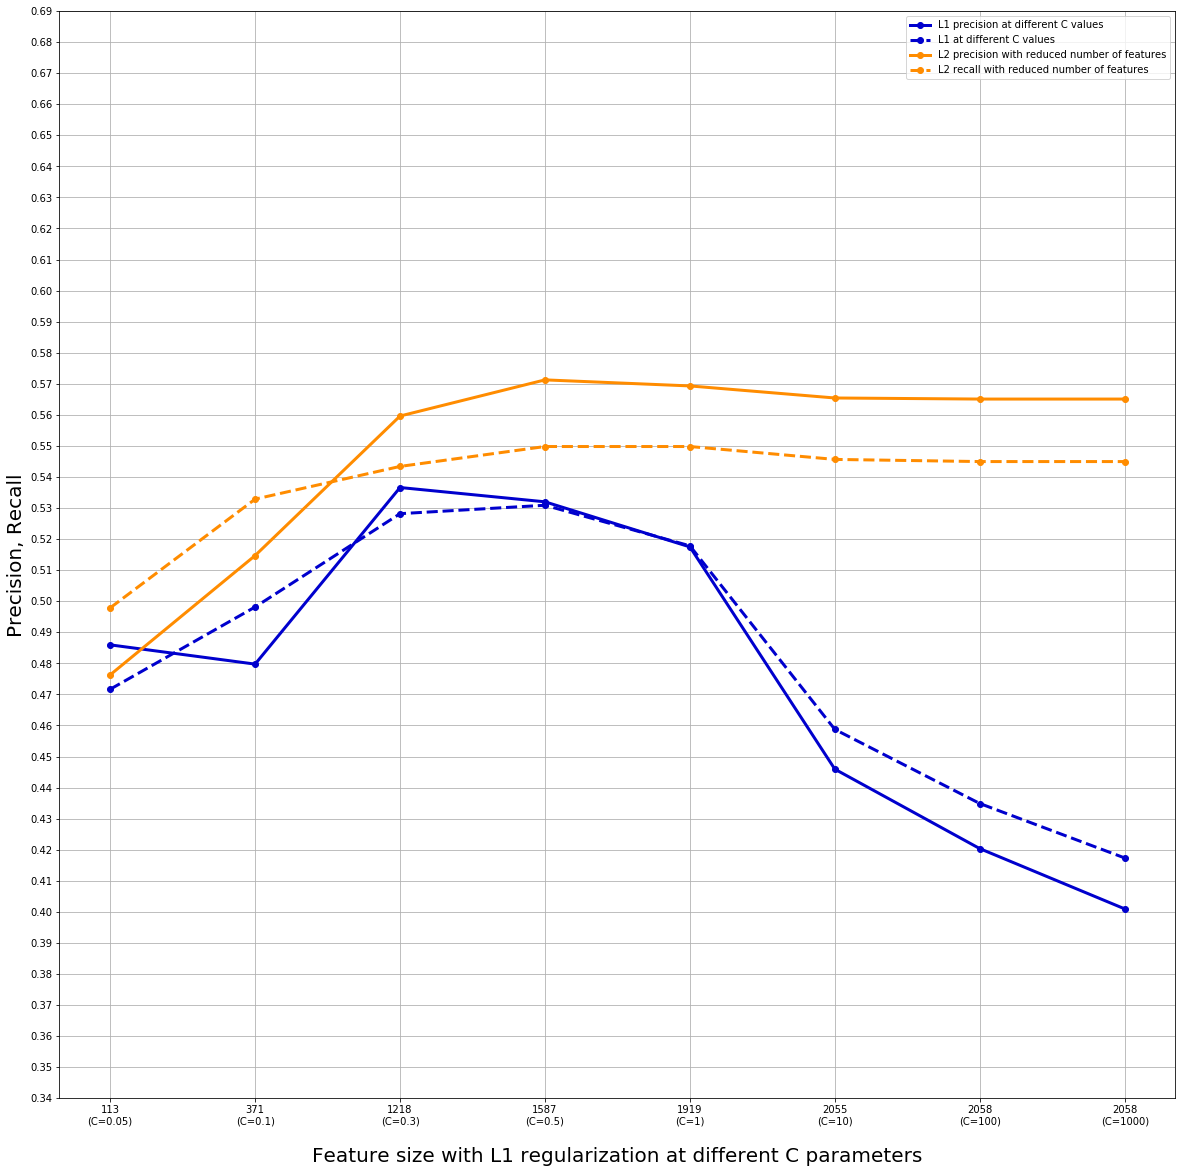

training data: (6004, 4778)
dev data     : (1502, 4778)
test data    : (2502, 4778)


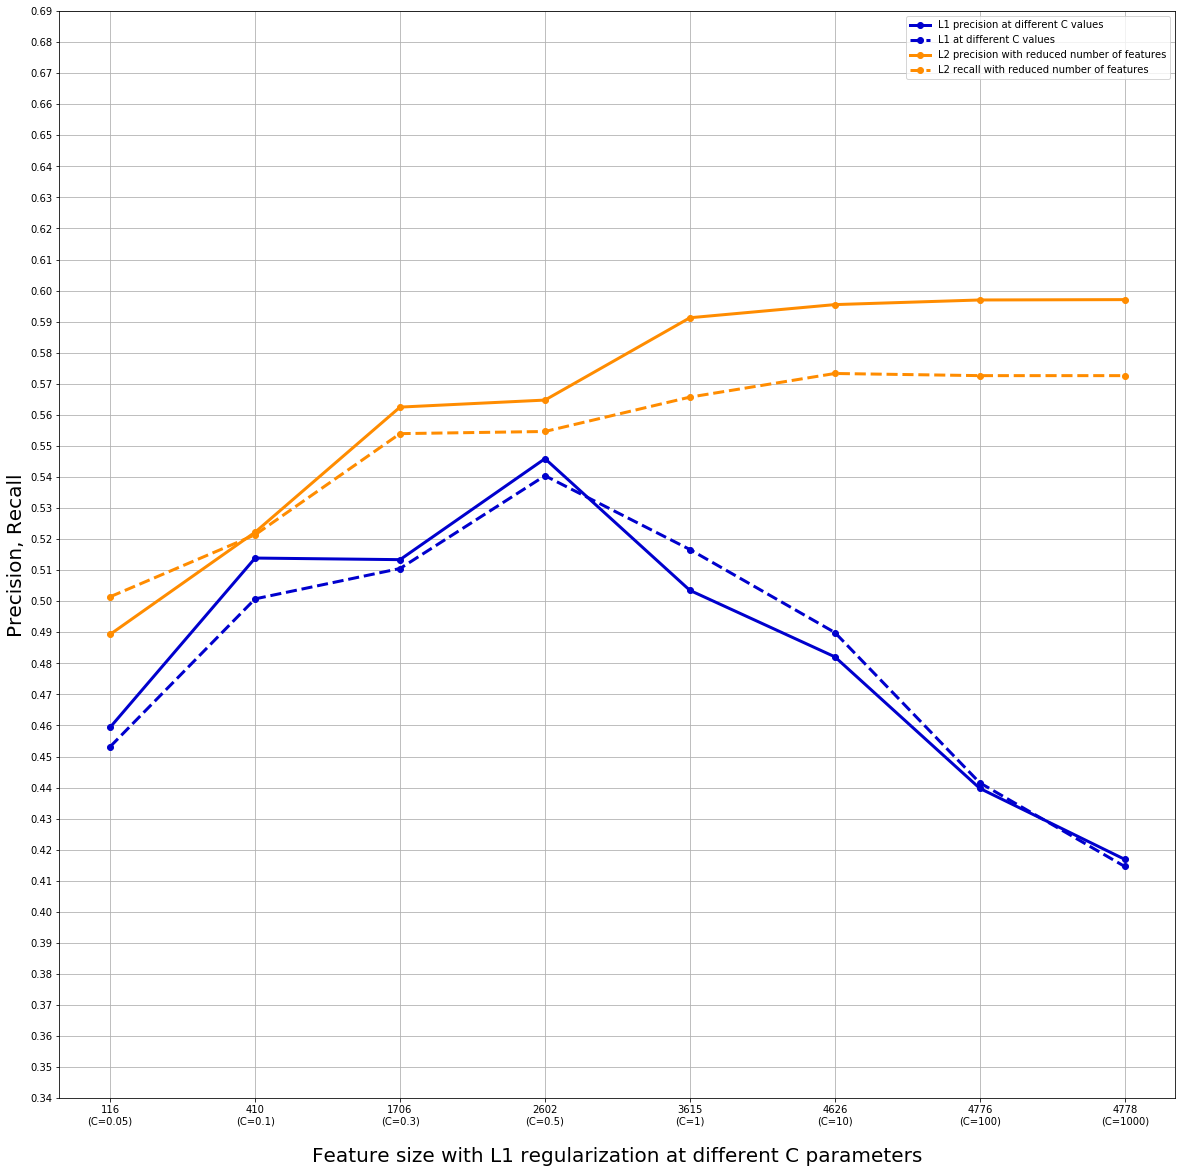

training data: (6004, 7184)
dev data     : (1502, 7184)
test data    : (2502, 7184)


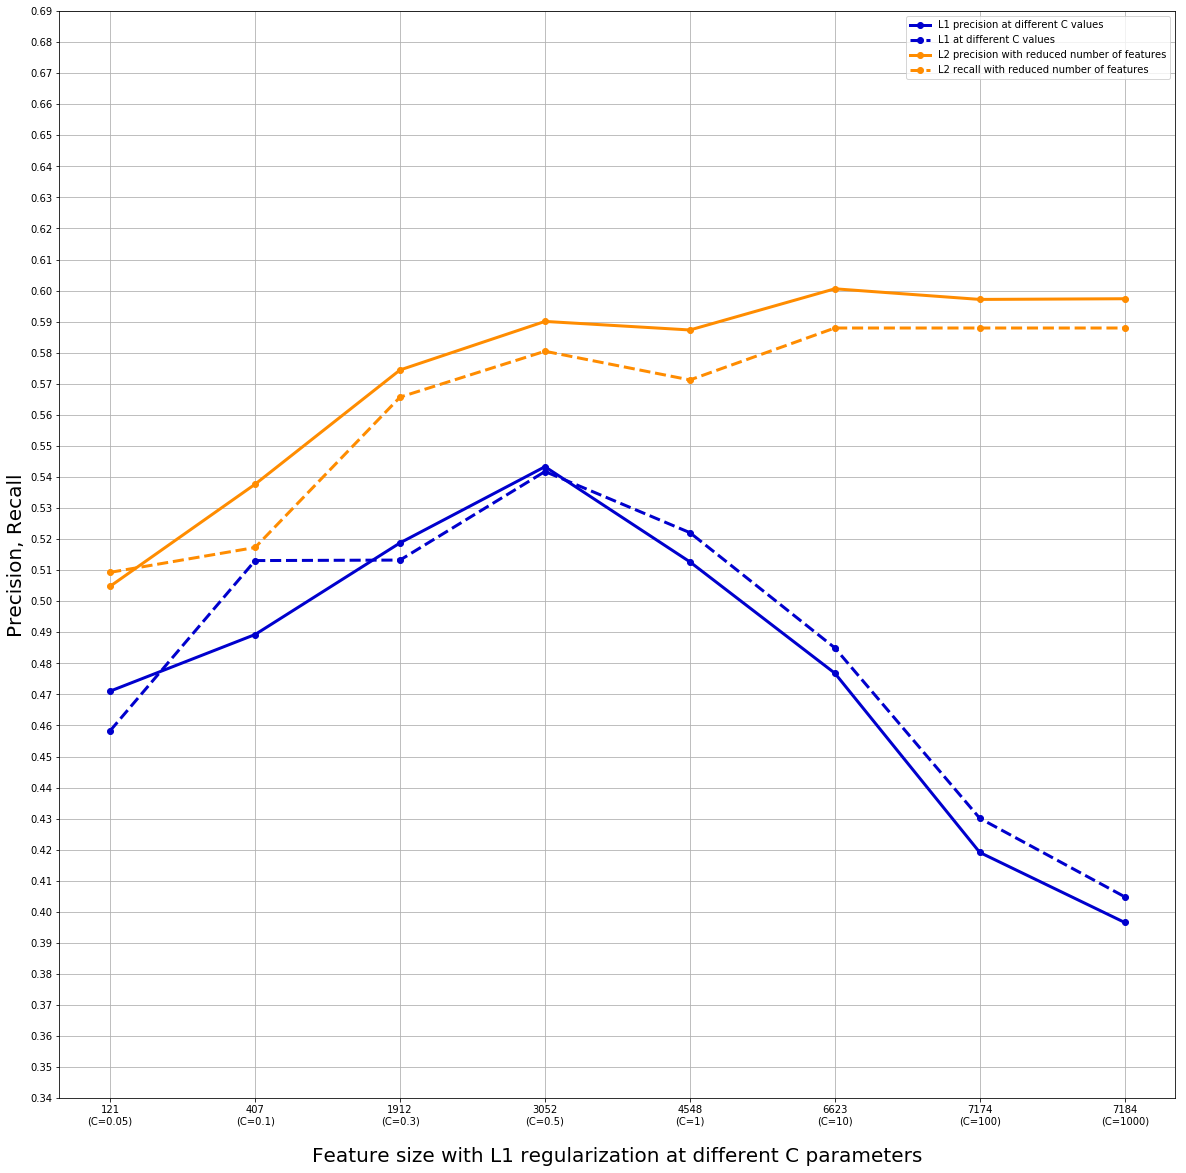

In [16]:
for top_n_genes, data_object in all_data.items():
    data   = data_object['data']
    labels = data_object['labels']
    splits = splitData(data, labels)
    eliminateFeatures(splits['train_data'], splits['train_labels'],
                      splits['dev_data'], splits['dev_labels'], logit_best_params)